In [1]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

# Percentage of used scripts in time

Observe how the used scripts changed over time. All scripts using witnesses are in the `SegWit` category.

CPU times: user 16min 51s, sys: 13.1 s, total: 17min 5s
Wall time: 5.35 s


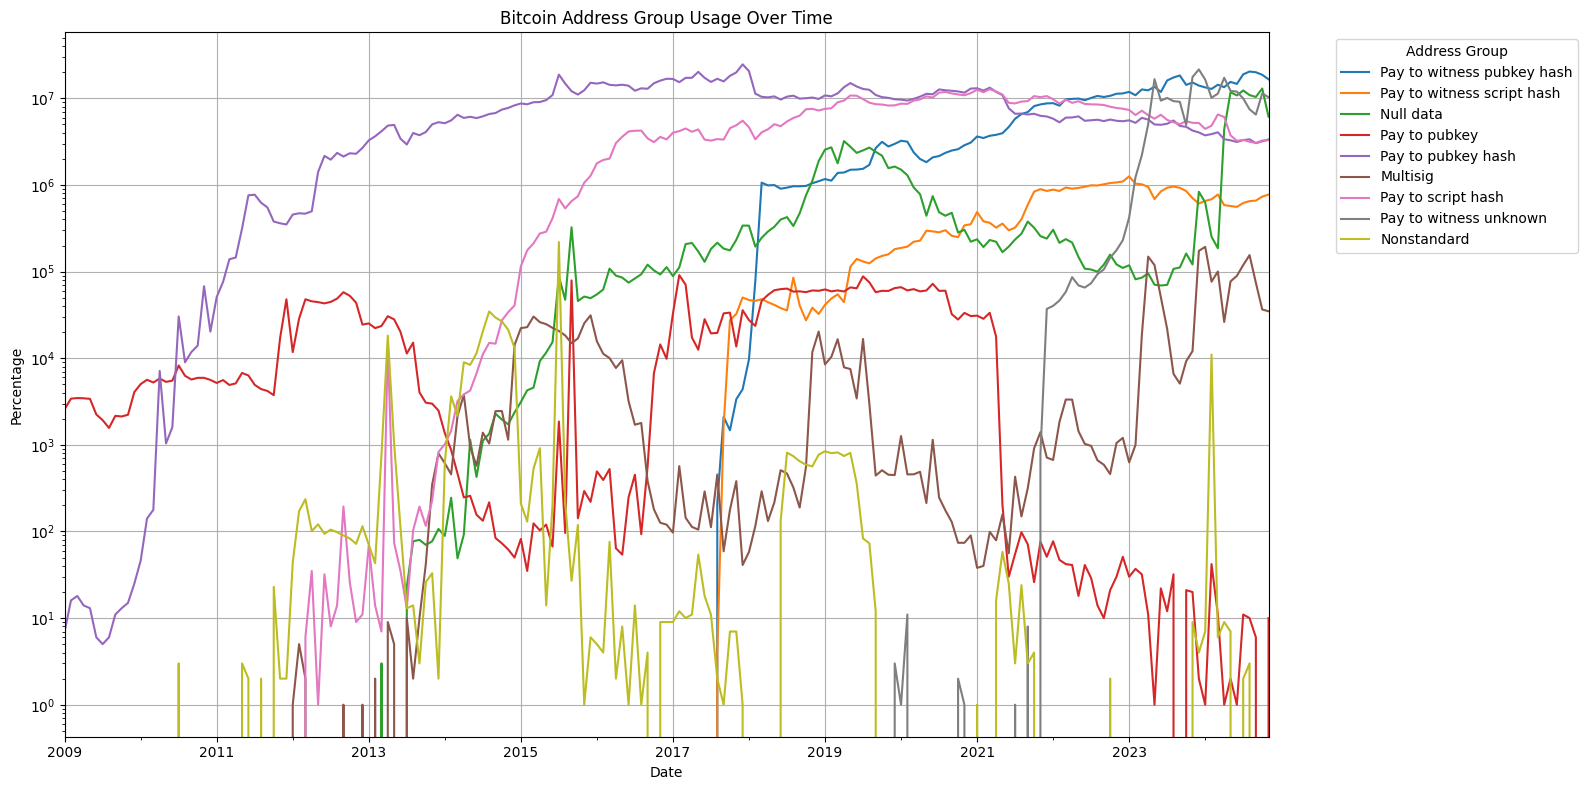

Pay to witness pubkey hash    5.998778e+08
Pay to witness script hash    4.102494e+07
Null data                     1.347893e+08
Pay to pubkey                 3.579348e+06
Pay to pubkey hash            1.366634e+09
Multisig                      2.058709e+06
Pay to script hash            7.422646e+08
Pay to witness unknown        2.340083e+08
Nonstandard                   4.445270e+05
dtype: float64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%time data = chain.get_count_of_address_types_for_each_day(0, len(chain))

df = pd.DataFrame.from_dict(data, orient='index')
df = df.fillna(0).T  # Transpose to make days the rows
df.index = pd.to_datetime(df.index.map(lambda x: datetime.utcfromtimestamp(x * 86400)))

group_mapping = {
    #blocksci.address_type.witness_pubkeyhash: "segwit",
    #blocksci.address_type.witness_unknown: "segwit",
    #blocksci.address_type.nonstandard: "", 
    #blocksci.address_type.witness_scripthash: "segwit",
}

# segwit_total = df[group_mapping.keys()].sum(axis=1)  # Sum up all segwit categories
# df["SegWit"] = segwit_total 

df = df.drop(columns=group_mapping.keys())

df = df.resample('M').sum()

# df['total'] = df.sum(axis=1)

# percentages = df.div(df['total'], axis=0) * 100
# percentages = percentages.drop(columns=['total'])


plt.figure(figsize=(16, 8))
df.plot(kind='line', ax=plt.gca())

plt.legend(title='Address Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Bitcoin Address Group Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.yscale('log')
plt.grid()

plt.tight_layout()

# plt.savefig('/mnt/blocksci/address_group_usage_percent.png')
plt.show()

print(df.sum())

# CoinJoins


In [4]:
last_october_block = get_block_height_for_date('2024-10-31')

%time ww2_coinjoins = chain.filter_coinjoin_txes(0, last_october_block, "wasabi2")
%time ww1_coinjoins = chain.filter_coinjoin_txes(0, last_october_block, "wasabi1")
%time sw_coinjoins = chain.filter_coinjoin_txes(0, last_october_block, "whirlpool")

print(len(ww2_coinjoins), len(ww1_coinjoins), len(sw_coinjoins))

CPU times: user 2.96 s, sys: 122 ms, total: 3.08 s
Wall time: 99.7 ms
2727 34728 541107


## Number of coinjoins in the wild

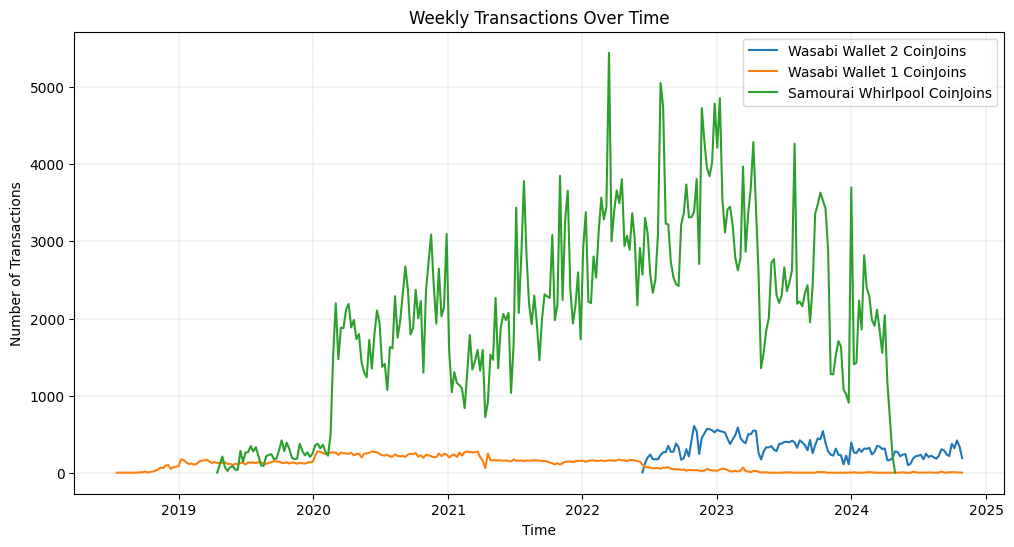

In [4]:
def process_transactions(transactions, label):
    transactions = list(map(lambda tx: {"block_time": tx.block_time}, transactions))
    df = pd.DataFrame(transactions)
    df['block_time'] = pd.to_datetime(df['block_time'])
    df['week'] = df['block_time'].dt.to_period('W').dt.to_timestamp()  # Get the timestamp for the start of the week
    weekly_counts = df.groupby('week').size()
    return weekly_counts, label

weekly_counts_ww2, label_1 = process_transactions(ww2_coinjoins, "Wasabi Wallet 2 CoinJoins")
weekly_counts_ww1, label_2 = process_transactions(ww1_coinjoins, "Wasabi Wallet 1 CoinJoins")
weekly_counts_sw, label_3 = process_transactions(sw_coinjoins, "Samourai Whirlpool CoinJoins")

plt.figure(figsize=(12, 6))

plt.plot(weekly_counts_ww2.index, weekly_counts_ww2.values, label=label_1)
plt.plot(weekly_counts_ww1.index, weekly_counts_ww1.values, label=label_2)
plt.plot(weekly_counts_sw.index, weekly_counts_sw.values, label=label_3)

plt.title("Weekly Transactions Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Transactions")
plt.legend()

plt.grid(True, linestyle='--', linewidth=0.3)
plt.savefig("/mnt/blocksci/weekly_cjs_over_time.png")

plt.show()


## Liquidity

In [5]:
tx: blocksci.Tx
i: blocksci.Input
from collections import defaultdict
from datetime import datetime, timedelta

def process_input_liquidity(cjs, label):
    input_liquitidy_per_date = {}
    s = set(cjs)
    
    for tx in cjs:
        tx_date = tx.block_time.date()
        if tx_date not in input_liquitidy_per_date:
            input_liquitidy_per_date[tx_date] = 0
    
        for i in tx.inputs:
            if i.spent_tx in s:
                continue
    
            input_liquitidy_per_date[tx_date] += i.value

    sorted_liquidity = {k: v // 100000000 for k, v in sorted(input_liquitidy_per_date.items(), key=lambda t: t[0])}
    

    return sorted_liquidity, label

liq1, lab1 = process_input_liquidity(ww2_coinjoins, "Wasabi2 Input Liquidity")
liq2, lab2 = process_input_liquidity(ww1_coinjoins, "Wasabi1 Input Liquidity")
liq3, lab3 = process_input_liquidity(sw_coinjoins, "Whirlpool Input Liquidity")

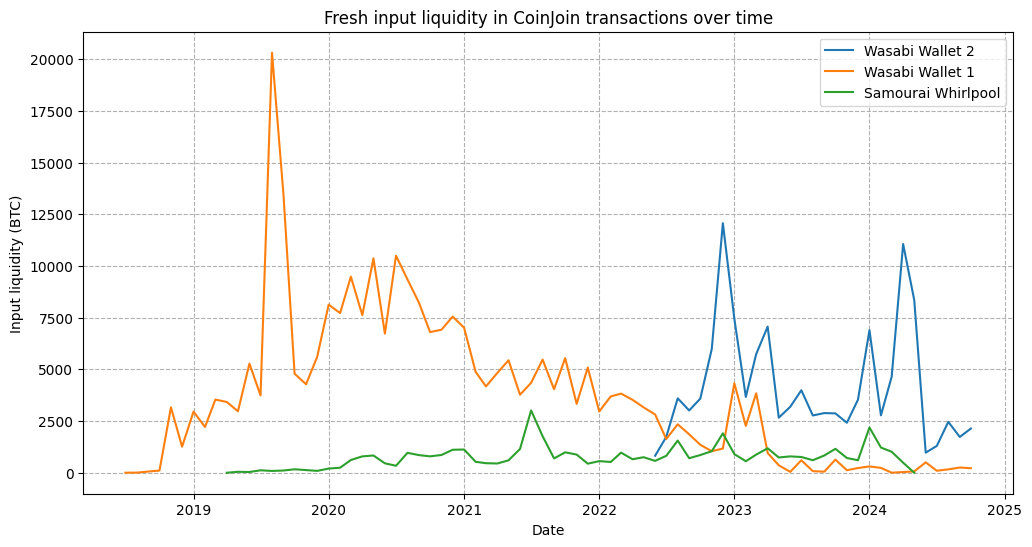

In [25]:
def group_by_week(data):
    weekly_data = defaultdict(int)
    for date, count in data.items():
        nd = datetime.combine(date, datetime.min.time())
        week_start = nd - timedelta(days=nd.weekday())
        weekly_data[week_start] += count

    for k in weekly_data:
        weekly_data[k] /= 7
    return dict(sorted(weekly_data.items()))

df_ww2 = pd.DataFrame([{"time": time, "count": count} for time, count in liq1.items()])
df_ww1 = pd.DataFrame([{"time": time, "count": count} for time, count in liq2.items()])
df_sw = pd.DataFrame([{"time": time, "count": count} for time, count in liq3.items()])
df_ww2['time'] = pd.to_datetime(df_ww2['time'])
df_ww1['time'] = pd.to_datetime(df_ww1['time'])
df_sw['time'] = pd.to_datetime(df_sw['time'])



df_ww2['week'] = df_ww2['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week
df_ww1['week'] = df_ww1['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week
df_sw['week'] = df_sw['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week

df_ww2 = df_ww2.groupby("week")["count"].sum().reset_index()
df_ww1 = df_ww1.groupby("week")["count"].sum().reset_index()
df_sw = df_sw.groupby("week")["count"].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_ww2["week"], df_ww2["count"], label="Wasabi Wallet 2")
plt.plot(df_ww1["week"], df_ww1["count"], label="Wasabi Wallet 1")
plt.plot(df_sw["week"], df_sw["count"], label="Samourai Whirlpool")
plt.title("Fresh input liquidity in CoinJoin transactions over time")
plt.xlabel("Date")
plt.ylabel("Input liquidity (BTC)")
plt.legend()
plt.grid(True, ls='--')
plt.savefig("/mnt/blocksci/liquidity.png")
plt.show()


## Traverses

In [18]:
%time flows = chain.find_traverses_between_coinjoins(0, get_block_height_for_date('2024-10-31'))

CPU times: user 25min 47s, sys: 6.61 s, total: 25min 53s
Wall time: 1min 44s


In [19]:
def cmp(cjt1, cjt2):
    return int(cjt1) < int(cjt2)

blocksci.CoinJoinType.__lt__ = cmp

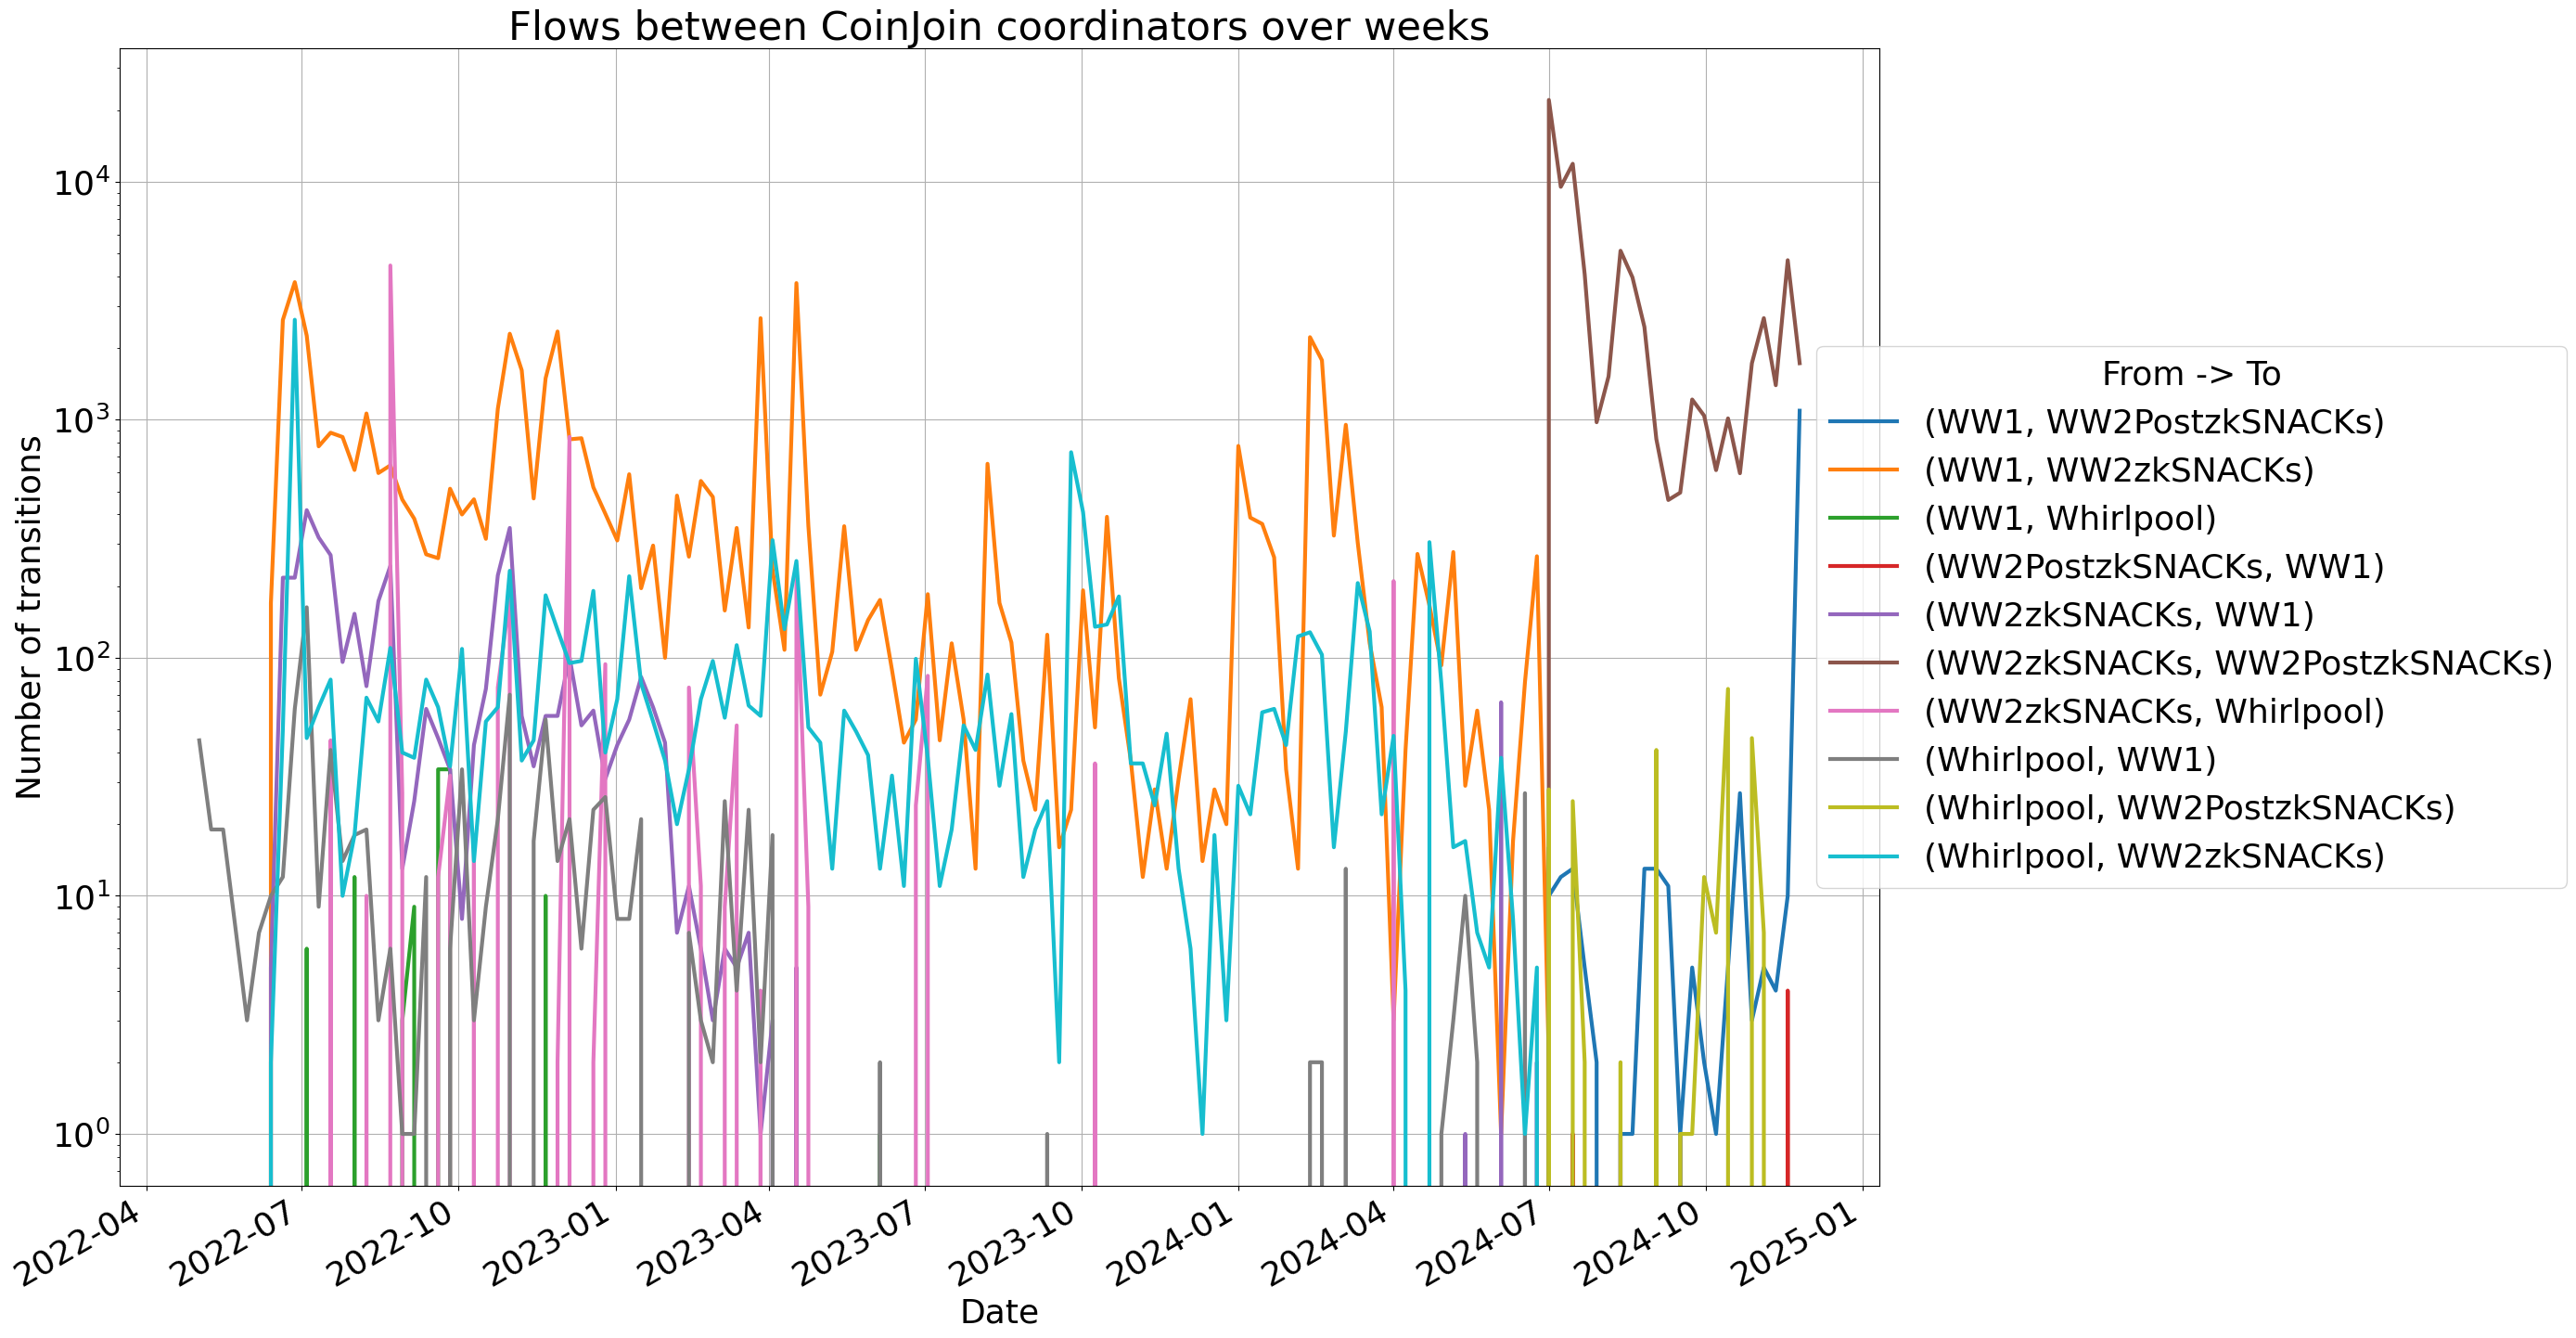

In [55]:
import datetime

# flatten and convert to enums
records = []
for dt, from_map in flows.items():
    for from_cj, to_map in from_map.items():
        for to_cj, count in to_map.items():
            time = chain[dt].time
            # non-relevant values before this date
            if time < datetime.datetime(2022, 5, 1):
                continue
            records.append({"datetime": time, "from_cj": str(blocksci.CoinJoinType(from_cj)).split('.')[1], "to_cj": str(blocksci.CoinJoinType(to_cj)).split('.')[1], "count": count})

df = pd.DataFrame(records)
df['datetime'] = pd.to_datetime(df['datetime'])
df['week'] = df['datetime'].dt.to_period('W').apply(lambda x: x.start_time)

unique_weeks = df['week'].unique()
unique_from_cj = df['from_cj'].unique()
unique_to_cj = df['to_cj'].unique()

full_index = pd.MultiIndex.from_product(
    [unique_weeks, unique_from_cj, unique_to_cj],
    names=["week", "from_cj", "to_cj"]
)

df['week'] = df['week'].dt.normalize()
df_full = df.groupby(['week', 'from_cj', 'to_cj'])['count'].sum().reset_index()
df_full = df_full.set_index(["week", "from_cj", "to_cj"]).reindex(full_index, fill_value=0).reset_index()

pivot_df = df_full.pivot_table(
    index="week",
    columns=["from_cj", "to_cj"],
    values="count",
    fill_value=0
)


pivot_df = pivot_df.drop(columns=pivot_df.columns[(pivot_df == 0).all()])
plt.rcParams.update({'font.size': 26})

pivot_df.plot(figsize=(30, 15), logy=True, linewidth=3)
plt.title("Flows between CoinJoin coordinators over weeks")
plt.xlabel("Date")
plt.ylabel("Number of transitions")
plt.legend(title="From -> To", loc="center right", bbox_to_anchor=(1.4, 0.5))
plt.tight_layout()
plt.grid(True)
plt.savefig("/mnt/blocksci/flows.png")


plt.show()


## Anonymity degradation

### calculation

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial


def plot_anonymity_degradation(original_data, after_day_data, after_week_data, after_month_data, after_year, after_all, tag):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
    df_original = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        columns=["block_time", "original_anonymity_score"],
    )

    df_after_day = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_day_data.items()],
        columns=["block_time", "anonymity_set_after_day"],
    )
    
    df_after_week = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_week_data.items()],
        columns=["block_time", "anonymity_set_after_week"],
    )
    df_after_month = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_month_data.items()],
        columns=["block_time", "anonymity_set_after_month"],
    )

    df_after_year = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_year.items()],
        columns=["block_time", "anonymity_set_after_year"],
    )

    df_after_all = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_all.items()],
        columns=["block_time", "anonymity_set_after_all"],
    )
    
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_after_day["block_time"] = pd.to_datetime(df_after_day["block_time"])
    df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])
    df_after_month["block_time"] = pd.to_datetime(df_after_month["block_time"])
    df_after_year["block_time"] = pd.to_datetime(df_after_year["block_time"])
    df_after_all["block_time"] = pd.to_datetime(df_after_all["block_time"])
    
    df_original["week_start"] = df_original["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_day["week_start"] = df_after_day["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_week["week_start"] = df_after_week["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_month["week_start"] = df_after_month["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_year["week_start"] = df_after_year["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_all["week_start"] = df_after_all["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    
    weekly_original = df_original.groupby("week_start")["original_anonymity_score"].mean().reset_index()
    weekly_after_day = df_after_day.groupby("week_start")["anonymity_set_after_day"].mean().reset_index()
    weekly_after_week = df_after_week.groupby("week_start")["anonymity_set_after_week"].mean().reset_index()
    weekly_after_month = df_after_month.groupby("week_start")["anonymity_set_after_month"].mean().reset_index()
    weekly_after_year = df_after_year.groupby("week_start")["anonymity_set_after_year"].mean().reset_index()
    weekly_after_all = df_after_all.groupby("week_start")["anonymity_set_after_all"].mean().reset_index()
    
    weekly_data = pd.merge(weekly_original, weekly_after_week, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_day, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_month, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_year, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_all, on="week_start", how="outer")
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 10))
    plt.plot(
        weekly_data["week_start"],
        weekly_data["original_anonymity_score"],
        label="Initial computed anonymity value",
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_day"],
        label="Computed anonymity value after 1 day",
        linestyle='dotted'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_week"],
        label="Computed anonymity value after 7 days",
        linestyle='dashed',
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_month"],
        label="Computed anonymity value after 31 days",
        linewidth=1,
        linestyle='dashdot'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_year"],
        label="Computed anonymity value after 365 days",
        linestyle='dotted'
    )

    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_all"],
        label="Computed anonymity value with no time limit",
        linestyle='dashed'
    )
    
    plt.xlabel("Week")
    plt.ylabel("Computed anonymity value")
    plt.title(f"Computed anonymity values for {tag.split('_')[0].upper()} CoinJoins")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.ylim(ymin=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_{tag}.png")
    plt.show()


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log2, factorial

def compute_and_plot_differences(original_data, after_day_data, after_week_data, after_month_data, after_year_data, tag):
    def make_df(data, col_name):
        df = pd.DataFrame(
            [(tx.block_time, val / log2(factorial(tx.output_count))) for tx, val in data.items()],
            columns=["block_time", col_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("M").apply(lambda r: r.start_time)
        return df

    df_original = make_df(original_data, "original_value")
    df_after_day = make_df(after_day_data, "after_day_value")
    df_after_week = make_df(after_week_data, "after_week_value")
    df_after_month = make_df(after_month_data, "after_month_value")
    df_after_year = make_df(after_year_data, "after_year_value")

    df_original = df_original.groupby("week_start")["original_value"].mean().reset_index()
    df_after_day = df_after_day.groupby("week_start")["after_day_value"].mean().reset_index()
    df_after_week = df_after_week.groupby("week_start")["after_week_value"].mean().reset_index()
    df_after_month = df_after_month.groupby("week_start")["after_month_value"].mean().reset_index()
    df_after_year = df_after_year.groupby("week_start")["after_year_value"].mean().reset_index()

    merged = df_original.merge(df_after_day, on="week_start", how="outer")
    merged = merged.merge(df_after_week, on="week_start", how="outer")
    merged = merged.merge(df_after_month, on="week_start", how="outer")
    merged = merged.merge(df_after_year, on="week_start", how="outer")

    merged["diff_0_1d"] = abs(merged["after_day_value"] - merged["original_value"])
    merged["diff_1d_7d"] = abs(merged["after_week_value"] - merged["after_day_value"])
    merged["diff_7d_31d"] = abs(merged["after_month_value"] - merged["after_week_value"])
    merged["diff_31d_365d"] = abs(merged["after_year_value"] - merged["after_month_value"])

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16,6))
    plt.plot(merged["week_start"], merged["diff_0_1d"], label="Difference (0–1d)")
    plt.plot(merged["week_start"], merged["diff_1d_7d"], label="Difference (1d–7d)", ls='--')
    plt.plot(merged["week_start"], merged["diff_7d_31d"], label="Difference (7d–31d)", ls=':')
    plt.plot(merged["week_start"], merged["diff_31d_365d"], label="Difference (31d–365d)", ls='-.')

    plt.xlabel("Month")
    plt.ylabel("Difference in anonymity value")
    plt.title(f"Differences (0–1d, 1d–7d, 7d–31d, 31d-365d) for {tag.split('_')[0].upper()} CoinJoins")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_differences_{tag}_all.png")
    plt.show()
    
    print("original mean", merged["original_value"].mean())
    print("after day", merged["after_day_value"].mean())
    print("after week", merged["after_week_value"].mean())
    print("after month", merged["after_month_value"].mean())
    print("after year", merged["after_year_value"].mean())


def compute_and_plot_quartiles(after_day_data, after_year_data, tag):
    def make_df(data, col_name):
        df = pd.DataFrame(
            [(tx.block_time, val / log2(factorial(tx.output_count))) for tx, val in data.items()],
            columns=["block_time", col_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
        return df

    df_after_day = make_df(after_day_data, "after_day_value")
    df_after_year = make_df(after_year_data, "after_year_value")

    merged = pd.merge(df_after_day, df_after_year, on=["block_time","week_start"], how="outer")

    weekly = merged.groupby("week_start").agg({
        "after_day_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
        "after_year_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
    }).reset_index()

    weekly.columns = [
        "week_start",
        "after_day_mean", "after_day_q1", "after_day_median", "after_day_q3",
        "after_year_mean", "after_year_q1", "after_year_median", "after_year_q3"
    ]
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 10))
    plt.plot(weekly["week_start"], weekly["after_day_mean"], label="After 1 day (mean)", color='blue')
    plt.fill_between(weekly["week_start"], weekly["after_day_q1"], weekly["after_day_q3"], color='blue', alpha=0.2, label="1 day (Q1–Q3)")

    plt.plot(weekly["week_start"], weekly["after_year_mean"], label="After 1 year (mean)", color='red')
    plt.fill_between(weekly["week_start"], weekly["after_year_q1"], weekly["after_year_q3"], color='red', alpha=0.2, label="1 year (Q1–Q3)")
    
    plt.xlabel("Week")
    plt.ylabel("Computed anonymity value")
    plt.title(f"After 1 day and 1 year anonymity values with quartiles for {tag.split('_')[0].upper()} CoinJoins")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_quartiles_{tag}_new.png")
    plt.show()


### results

In [64]:
%time ww1_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1")
%time ww1_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1")
%time ww1_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1")
%time ww1_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1")
%time ww1_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1")
%time ww1_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1")

%time ww2_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2")
%time ww2_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2")
%time ww2_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2")
%time ww2_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2")
%time ww2_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2")
%time ww2_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2")



%time sw_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool")
%time sw_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool")
%time sw_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool")
%time sw_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool")
%time sw_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool")
%time sw_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool")


CPU times: user 2min 30s, sys: 615 ms, total: 2min 31s
Wall time: 2.59 s
CPU times: user 27min 37s, sys: 1.69 s, total: 27min 38s
Wall time: 12.8 s
CPU times: user 28min 6s, sys: 711 ms, total: 28min 7s
Wall time: 13.3 s
CPU times: user 29min 12s, sys: 3.08 s, total: 29min 15s
Wall time: 12.7 s
CPU times: user 29min 22s, sys: 3.53 s, total: 29min 25s
Wall time: 13.6 s
CPU times: user 28min 36s, sys: 901 ms, total: 28min 37s
Wall time: 14.3 s
CPU times: user 1min 44s, sys: 306 ms, total: 1min 44s
Wall time: 1.15 s
CPU times: user 28min 35s, sys: 1.82 s, total: 28min 37s
Wall time: 11.4 s
CPU times: user 28min 15s, sys: 5.48 s, total: 28min 21s
Wall time: 12 s
CPU times: user 28min 29s, sys: 975 ms, total: 28min 30s
Wall time: 11.4 s
CPU times: user 28min 49s, sys: 740 ms, total: 28min 50s
Wall time: 12.1 s
CPU times: user 29min 1s, sys: 3.94 s, total: 29min 5s
Wall time: 12.5 s
CPU times: user 1min 52s, sys: 1.34 s, total: 1min 53s
Wall time: 2.53 s
CPU times: user 40min 34s, sys: 6.53 

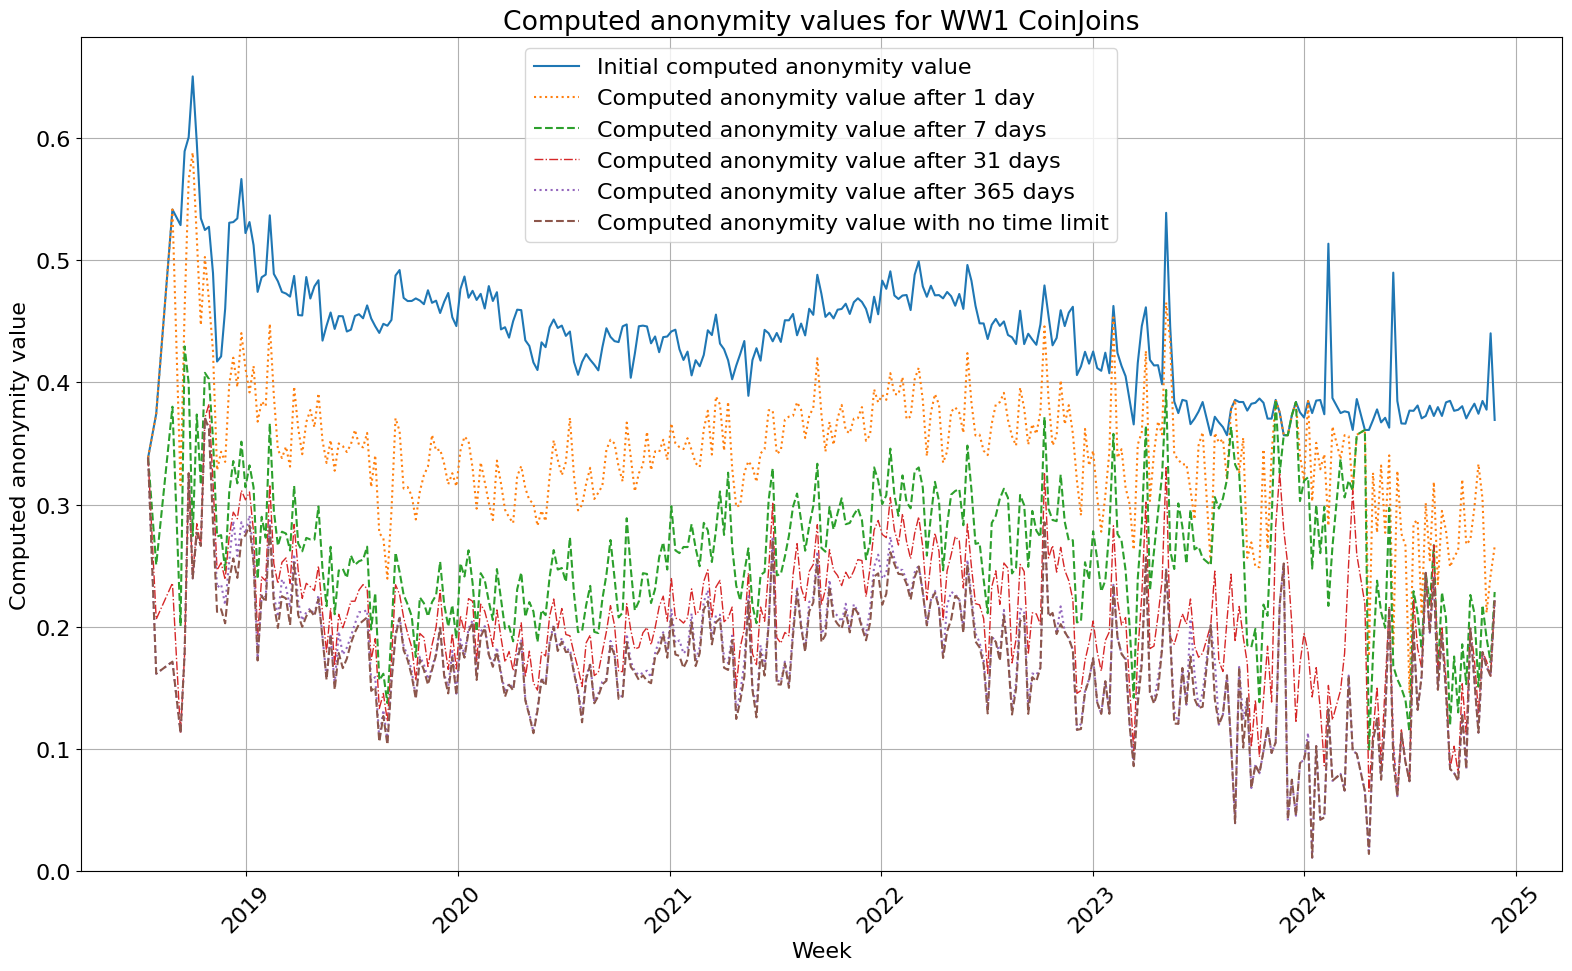

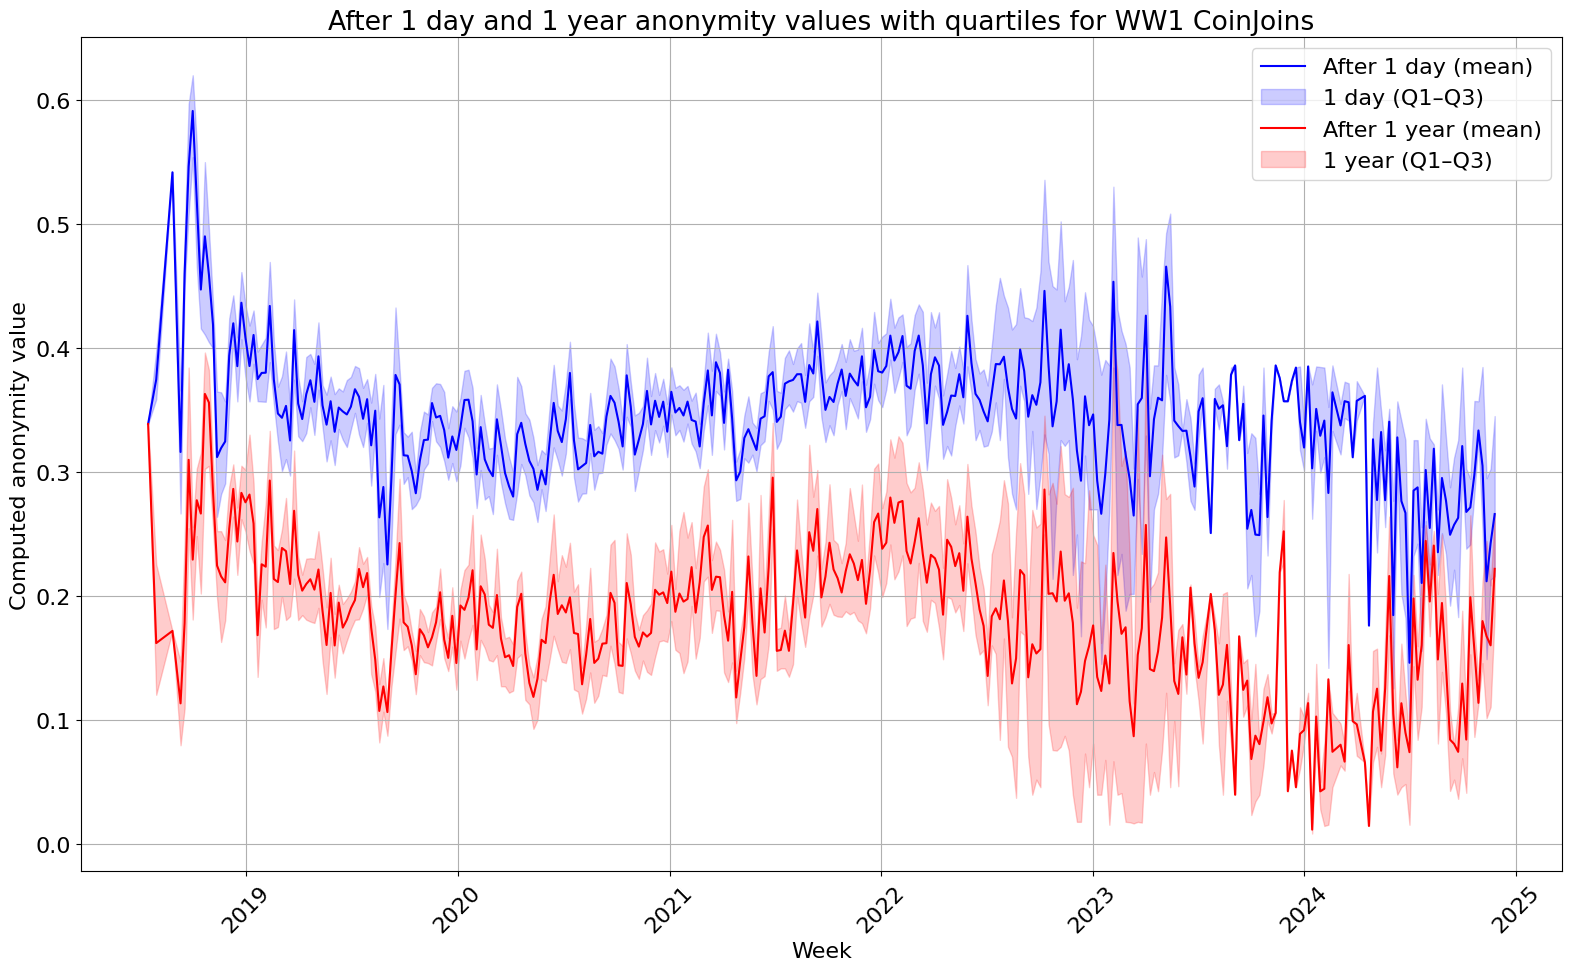

diffed
plotted


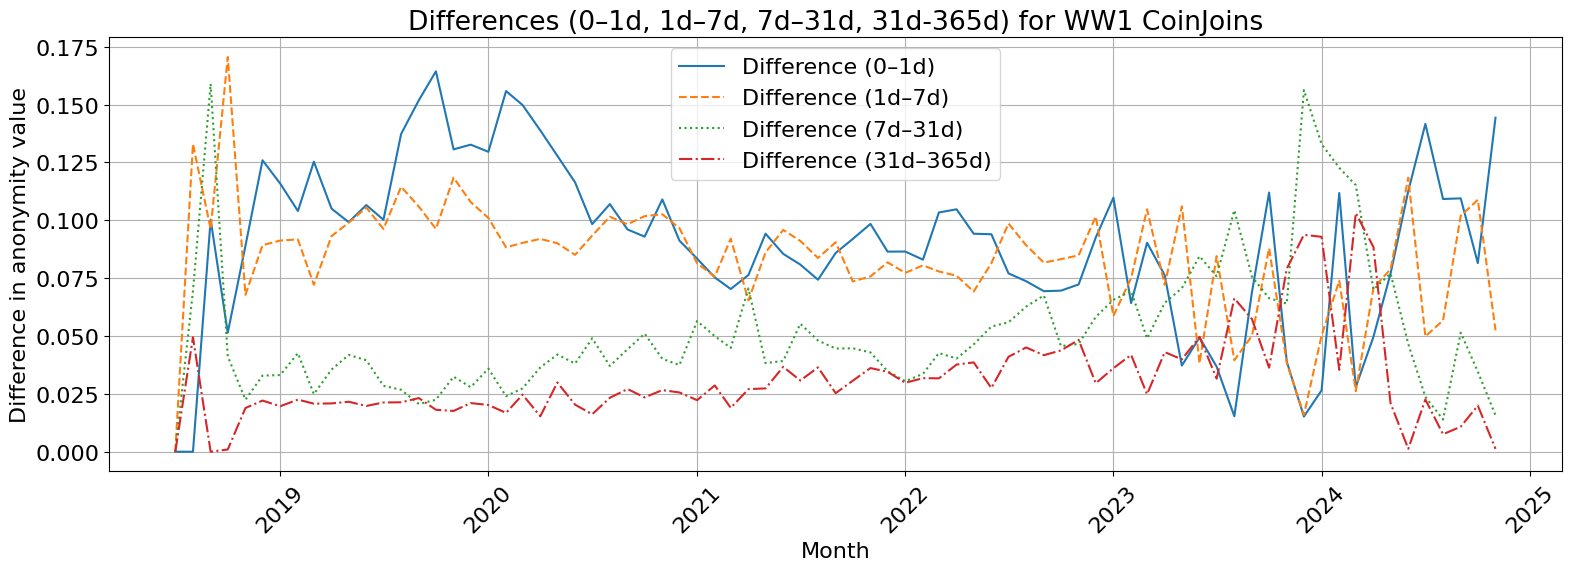

original mean 0.4356599529634524
after day 0.3449988844531357
after week 0.2613295843180302
after month 0.20981424633193266
after year 0.1784721199136009


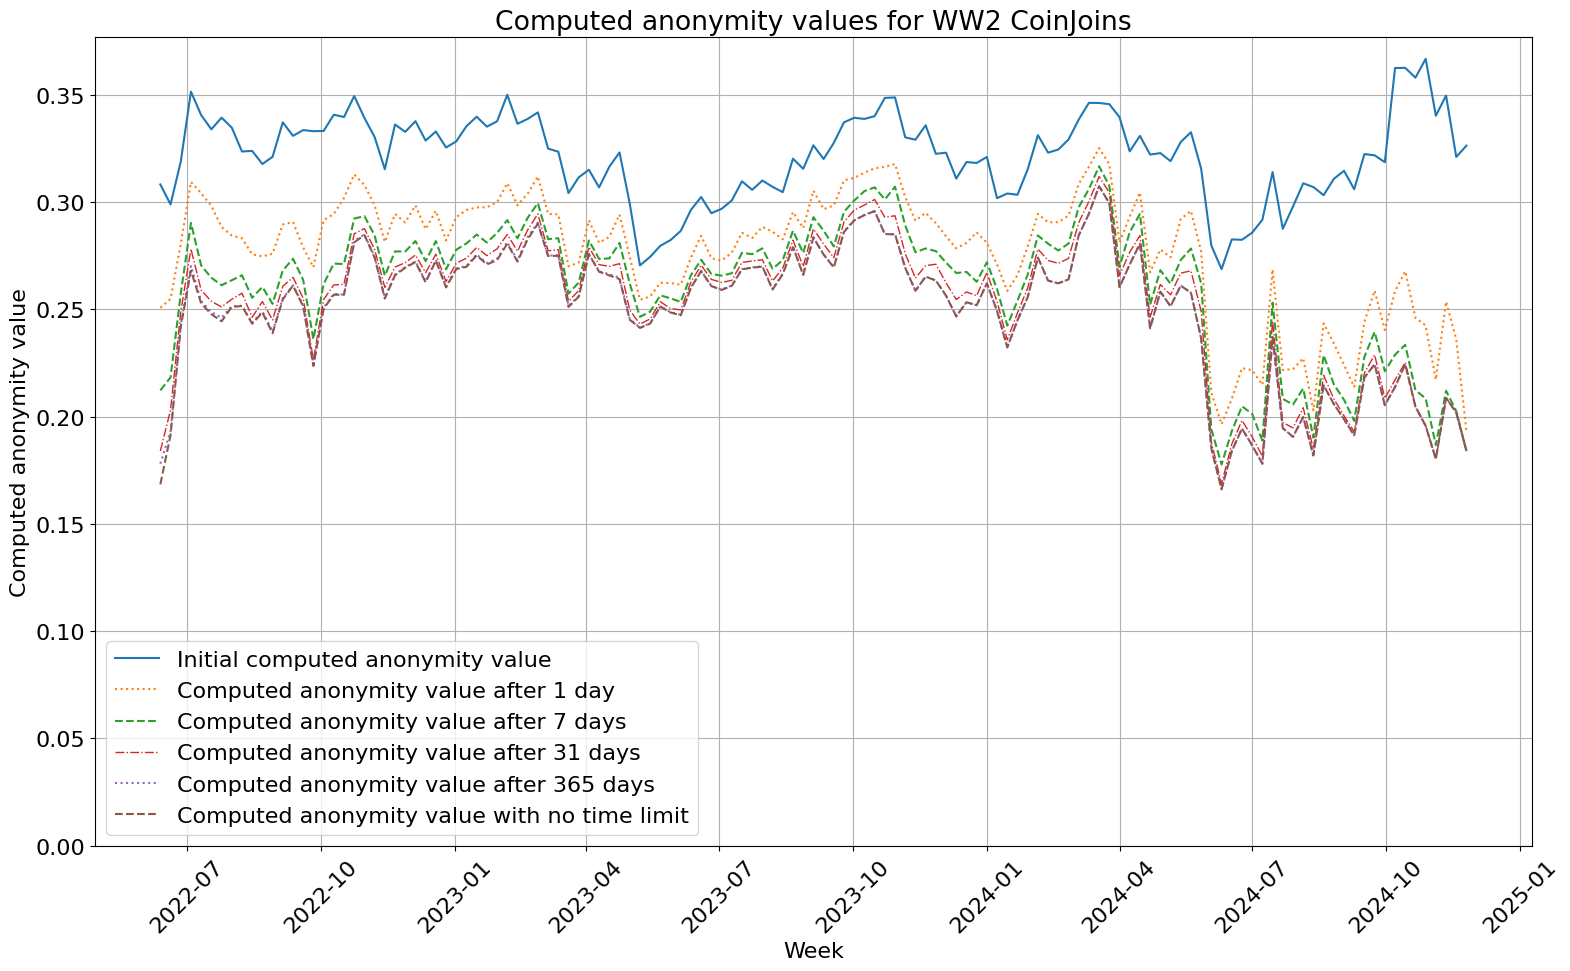

diffed
plotted


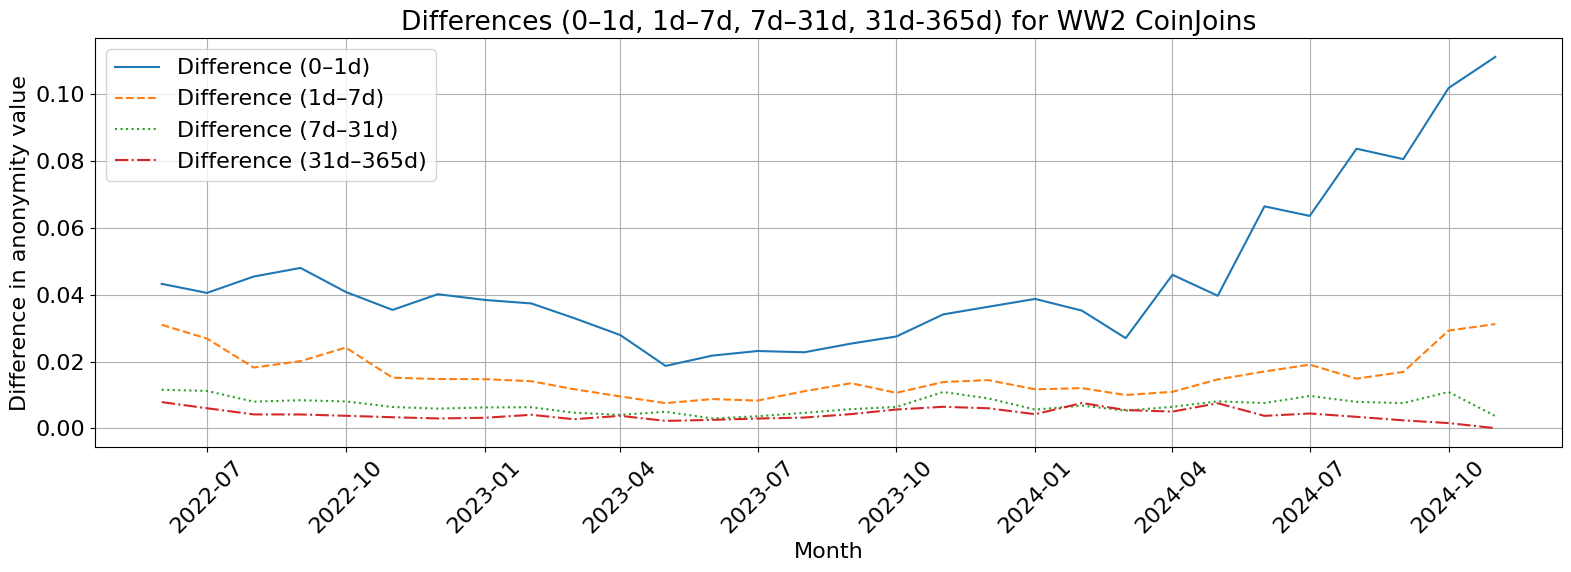

original mean 0.3217092803482106
after day 0.2772200534212101
after week 0.2613505890490464
after month 0.25440691266565196
after year 0.25026230554054885


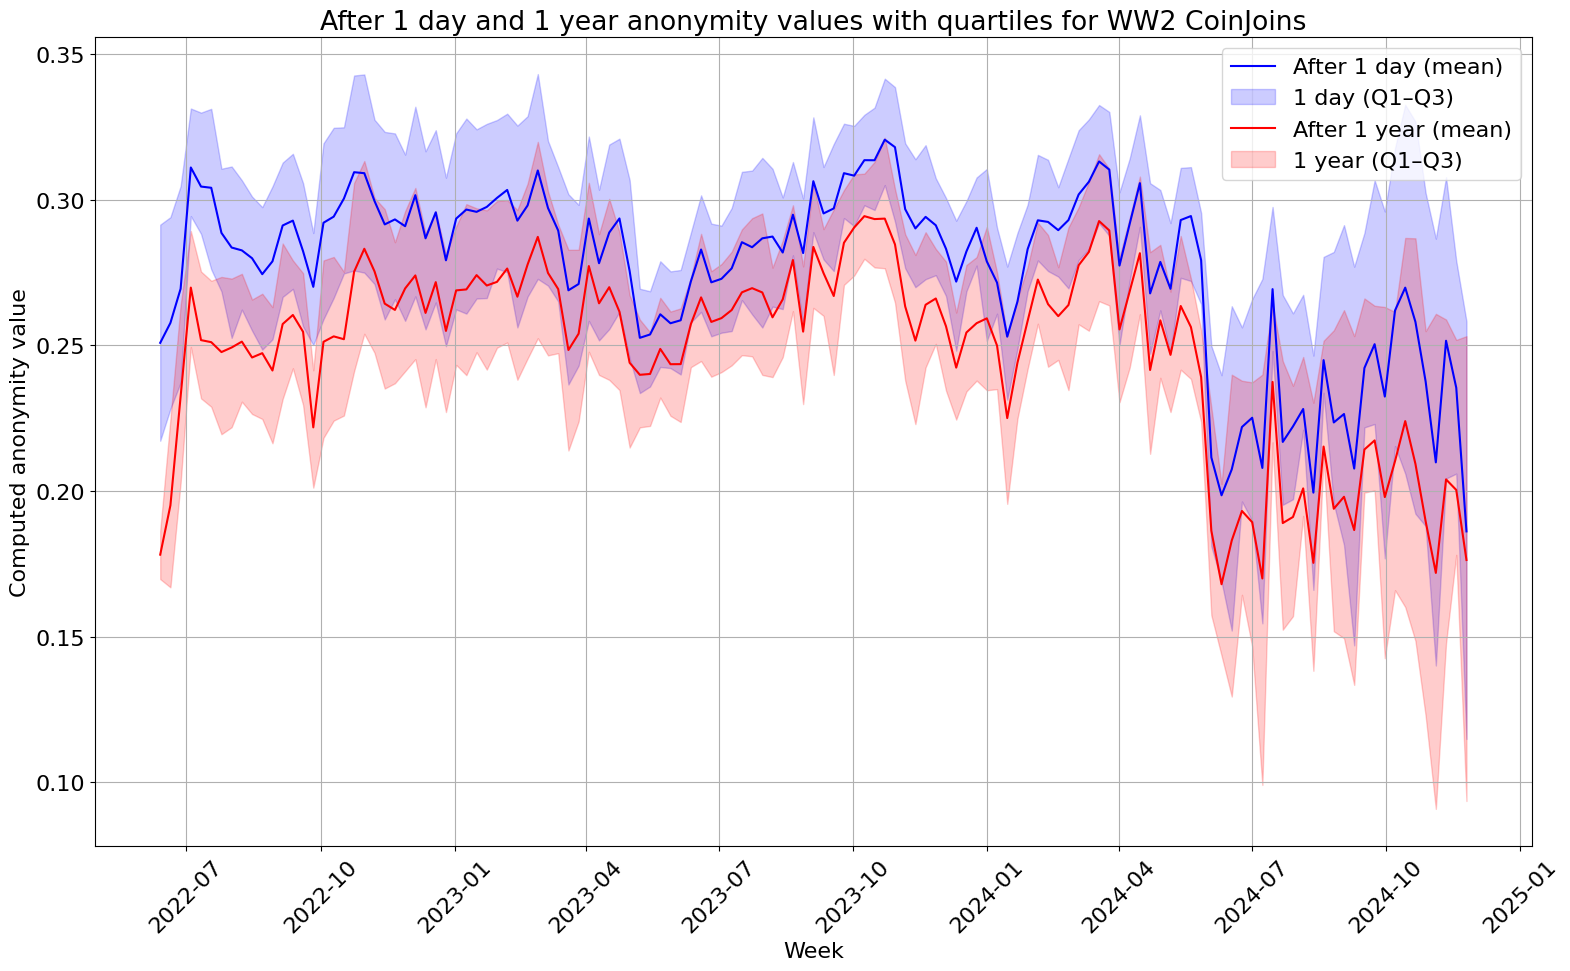

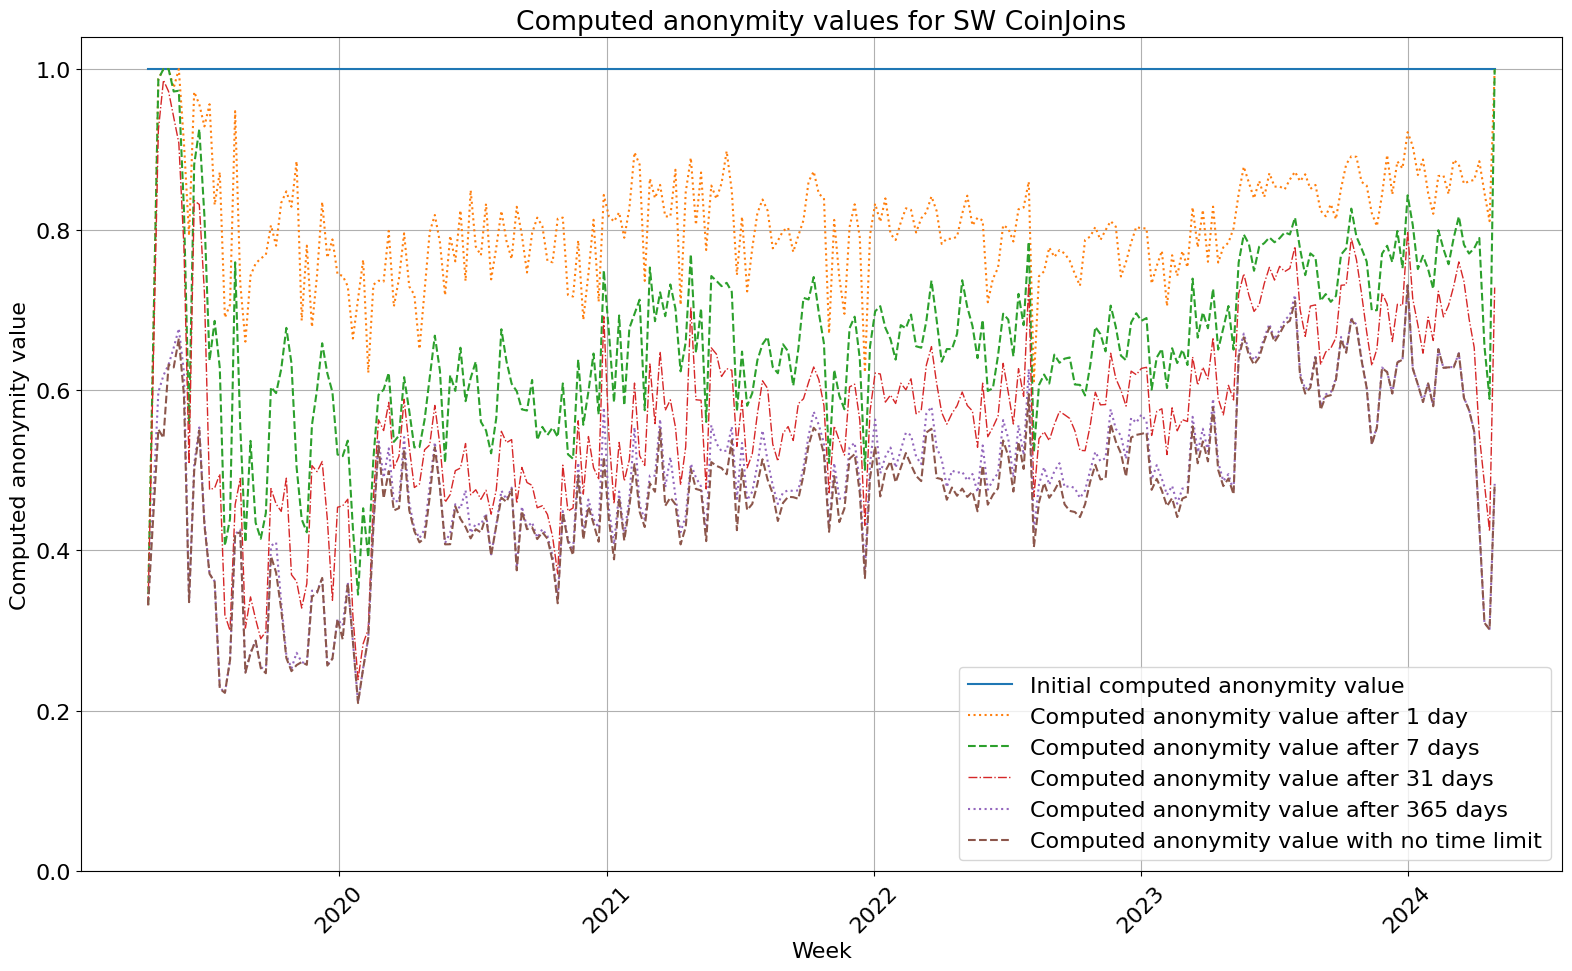

diffed
plotted


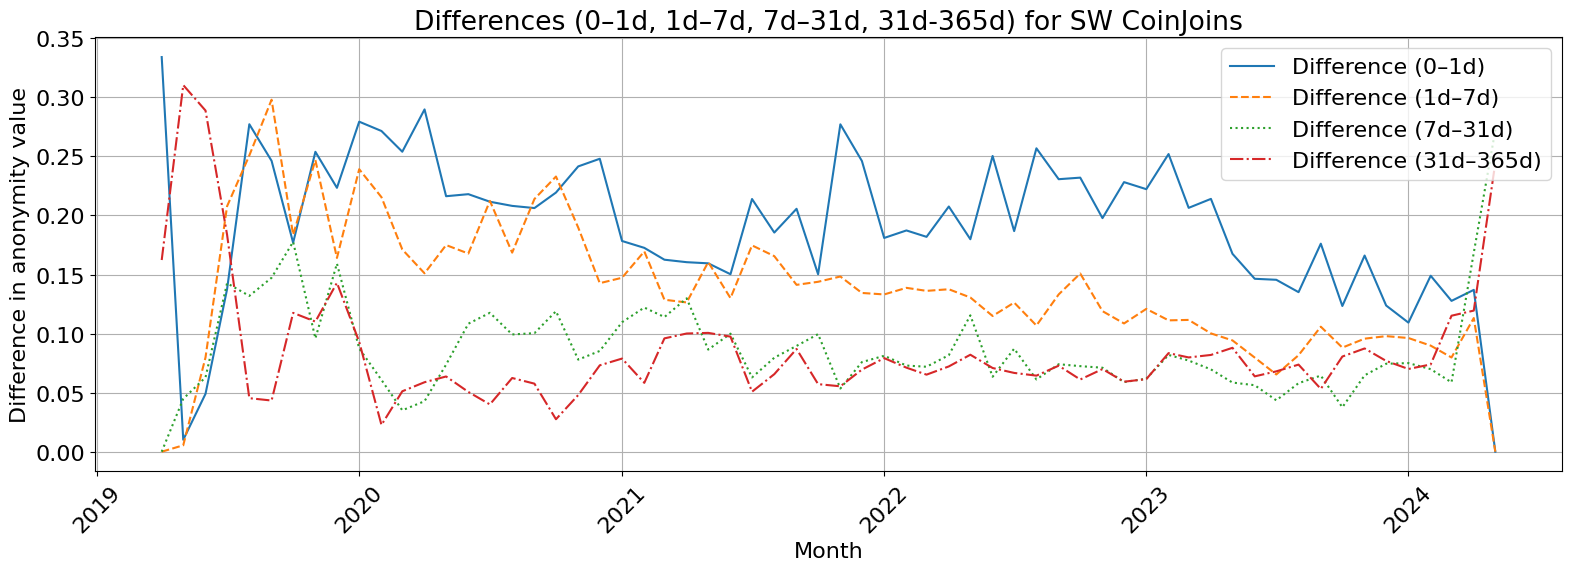

original mean 1.0
after day 0.8071822886786534
after week 0.6692383396088559
after month 0.5821963838715191
after year 0.4962977216204447


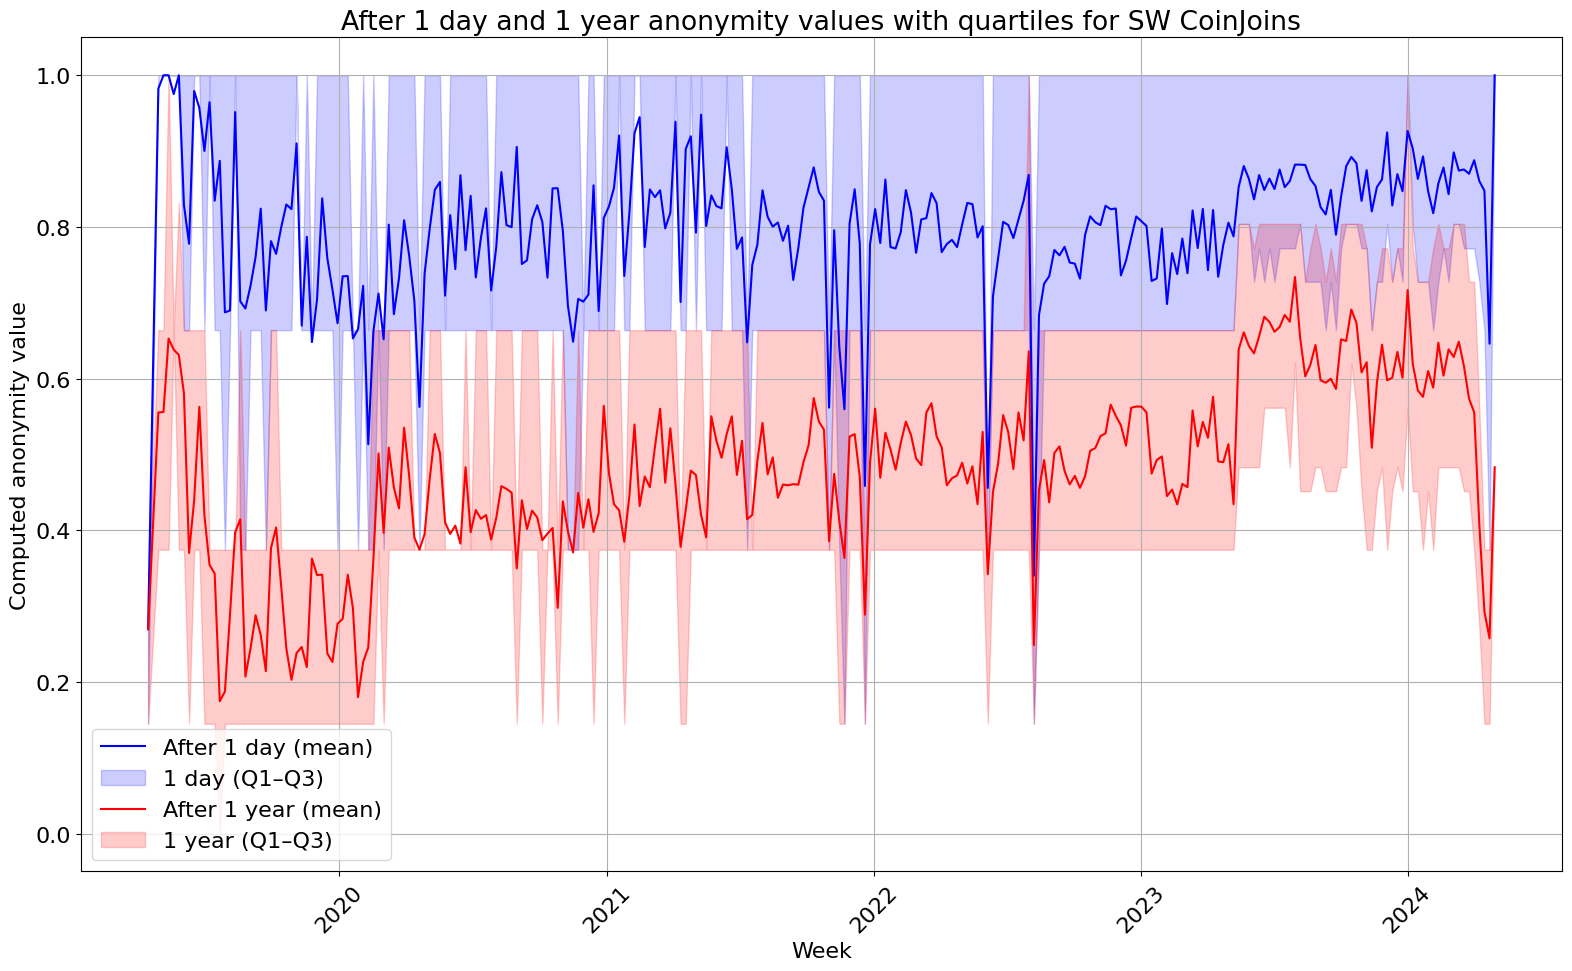

In [63]:
plot_anonymity_degradation(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, ww1_after_full_data, "ww1_multiple_txes")
compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")

plot_anonymity_degradation(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, ww2_after_full_data, "ww2_multiple_txes")
compute_and_plot_differences(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, "ww2_multiple_txes")
compute_and_plot_quartiles(ww2_after_day_data, ww2_after_year_data, "ww2_cjs")

plot_anonymity_degradation(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, sw_after_full_data, "sw_multiple_txes")
compute_and_plot_differences(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, "sw_multiple_txes")
compute_and_plot_quartiles(sw_after_day_data, sw_after_year_data, "sw_cjs")